In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/ML_AV/KAN

/content/drive/MyDrive/ML_AV/KAN


In [3]:
%cd torch-conv-kan

/content/drive/MyDrive/ML_AV/KAN/torch-conv-kan


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/ML_AV/KAN')
from kan_convs.kan_conv import KANConv2DLayer as ConvKAN

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn.functional as F
from tqdm import tqdm
import gc



In [6]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()

        self.conv_1x1_branch1 = nn.Sequential(
            ConvKAN(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_3x3_branch2 = nn.Sequential(
            ConvKAN(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6, grid_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_3x3_branch3 = nn.Sequential(
            ConvKAN(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12, grid_size=6),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_3x3_branch4 = nn.Sequential(
            ConvKAN(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18, grid_size=9),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.global_avg_pool_branch5 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.ReLU()
        )
        #self.conv_1x1_output = nn.Sequential(
        #    ConvKAN(out_channels * 5, out_channels, kernel_size=1, stride=1),
        #    LayerNorm2D(out_channels)
        #)
        self.conv_1x1_output = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        size = x.shape[2:]

        image_features = self.global_avg_pool_branch5(x)
        image_features = F.interpolate(image_features, size=size, mode='bilinear', align_corners=False)

        conv_1x1 = self.conv_1x1_branch1(x)
        conv_3x3_1 = self.conv_3x3_branch2(x)
        conv_3x3_2 = self.conv_3x3_branch3(x)
        conv_3x3_3 = self.conv_3x3_branch4(x)

        x = torch.cat([image_features, conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3], dim=1)
        x = self.conv_1x1_output(x)

        return x


In [7]:
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 196MB/s]


In [8]:
class DeepLabV3Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeepLabV3Encoder, self).__init__()
        self.backbone = resnet101
        self.aspp = ASPP(2048, out_channels)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        low_level_features = self.backbone.layer1(x)
        x = self.backbone.layer2(low_level_features)
        x = self.backbone.layer3(x)
        high_level_features = self.backbone.layer4(x)
        aspp_output = self.aspp(high_level_features)
        return aspp_output, low_level_features

In [9]:
class DeepLabV3Decoder(nn.Module):
    def __init__(self, low_level_in_channels, low_level_out_channels, num_classes):
        super(DeepLabV3Decoder, self).__init__()
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(low_level_in_channels, low_level_out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(low_level_out_channels),
            nn.ReLU()
        )
        self.concat_conv = nn.Sequential(
            nn.Conv2d(low_level_out_channels + 256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, aspp_output, low_level_features):
        low_level_features = self.low_level_conv(low_level_features)
        aspp_output = F.interpolate(aspp_output, size=low_level_features.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((aspp_output, low_level_features), dim=1)
        x = self.concat_conv(x)
        x = self.classifier(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        return x

In [10]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepLabV3Plus, self).__init__()
        self.encoder = DeepLabV3Encoder(in_channels=in_channels, out_channels=256)
        self.decoder = DeepLabV3Decoder(low_level_in_channels=256, low_level_out_channels=48, num_classes=num_classes)

    def forward(self, x):
        aspp_output, low_level_features = self.encoder(x)
        x = self.decoder(aspp_output, low_level_features)
        return x

In [11]:
from torchsummary import summary
deeplabv3_plus = DeepLabV3Plus(in_channels=3, num_classes=19)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deeplabv3_plus = deeplabv3_plus.to(device)
summary(deeplabv3_plus, (3, 768, 768))
print(deeplabv3_plus)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           9,408
       BatchNorm2d-2         [-1, 64, 384, 384]             128
              ReLU-3         [-1, 64, 384, 384]               0
         MaxPool2d-4         [-1, 64, 192, 192]               0
            Conv2d-5         [-1, 64, 192, 192]           4,096
       BatchNorm2d-6         [-1, 64, 192, 192]             128
              ReLU-7         [-1, 64, 192, 192]               0
            Conv2d-8         [-1, 64, 192, 192]          36,864
       BatchNorm2d-9         [-1, 64, 192, 192]             128
             ReLU-10         [-1, 64, 192, 192]               0
           Conv2d-11        [-1, 256, 192, 192]          16,384
      BatchNorm2d-12        [-1, 256, 192, 192]             512
           Conv2d-13        [-1, 256, 192, 192]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [56]:
import os
from torchvision.utils import make_grid
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2



class CityscapesDataset(Dataset):
    def __init__(self, root_dir, mode='train', img_size=(768, 768)):
        self.root_dir = root_dir
        self.mode = mode
        self.img_size = img_size

        self.image_paths = []
        self.mask_paths = []

        image_base_dir = os.path.join(root_dir, 'leftImg8bit_trainvaltest/leftImg8bit', mode)
        label_base_dir = os.path.join(root_dir, 'gtFine_trainvaltest/gtFine', mode)

        if not os.path.exists(image_base_dir) or not os.path.exists(label_base_dir):
            raise FileNotFoundError(f"Directories {image_base_dir} or {label_base_dir} do not exist.")

        for city in os.listdir(image_base_dir):
            city_image_dir = os.path.join(image_base_dir, city)
            city_label_dir = os.path.join(label_base_dir, city)

            if os.path.isdir(city_image_dir):
                for image_file in os.listdir(city_image_dir):
                    if image_file.endswith('.png'):
                        self.image_paths.append(os.path.join(city_image_dir, image_file))
                        label_file = image_file.replace('leftImg8bit', 'gtFine_labelIds')
                        self.mask_paths.append(os.path.join(city_label_dir, label_file))

        self.label_map = {
            0: 255,  1: 255,  2: 255,  3: 255,  4: 255,  5: 255,  6: 255,
            7: 0,    8: 1,    9: 255,  10: 255, 11: 2,   12: 3,   13: 4,
            14: 255, 15: 255, 16: 255, 17: 5,   18: 255, 19: 6,   20: 7,
            21: 8,   22: 9,   23: 10,  24: 11,  25: 12,  26: 13,  27: 14,
            28: 15,  29: 255, 30: 255, 31: 16,  32: 17,  33: 18,  -1: 255
        }

        self.train_transforms = A.Compose([
                      A.RandomScale(scale_limit=(0.5, 2), p=0.7),
                      A.RandomCrop(height=768, width=768),
                      A.HorizontalFlip(p=0.5),
                      A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, p=0.5),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                      ToTensorV2()])

        self.eval_transforms = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if image is None or label is None:
            raise RuntimeError(f"Failed to load image or label at index {idx}")

        label = self.map_labels(label)

        # Apply transformations
        if self.mode == 'train':
            transformed = self.train_transforms(image=image, mask=label)
        else:
            transformed = self.eval_transforms(image=image, mask=label)

        image, label = transformed['image'], transformed['mask']

        return image, label

    def map_labels(self, label):
        mapped_label = np.zeros_like(label, dtype=np.uint8)
        for id_, trainId in self.label_map.items():
            mapped_label[label == id_] = trainId
        return mapped_label




In [13]:
from torchvision import transforms

# Set the root directory where the Cityscapes dataset is stored
root_dir = '/content/drive/MyDrive/ML_AV/Deeplab/cityscape'

# Create the dataset
train_dataset = CityscapesDataset(
    root_dir=root_dir,
    mode='train',
)

Sample 1:
  Image range: min=-1.9809058904647827, max=2.6051416397094727
  Unique labels in mask: [  0   1   2   5   6   7   8  10  11  13 255]
  Labels count: 11


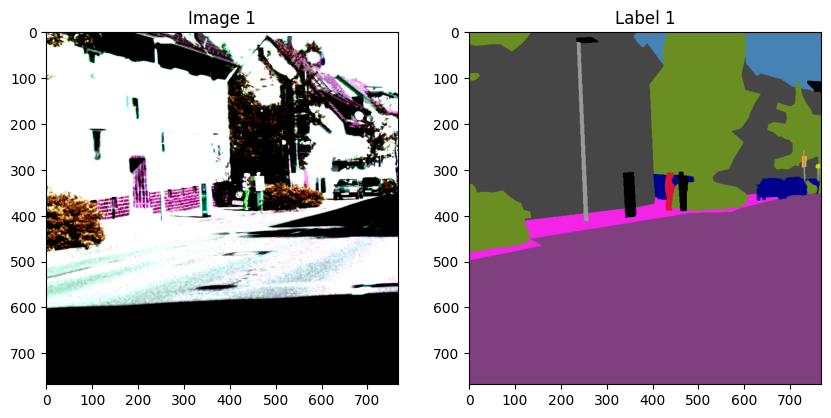

Sample 2:
  Image range: min=-2.0836544036865234, max=0.957983136177063
  Unique labels in mask: [  1   2   4   8   9 255]
  Labels count: 6


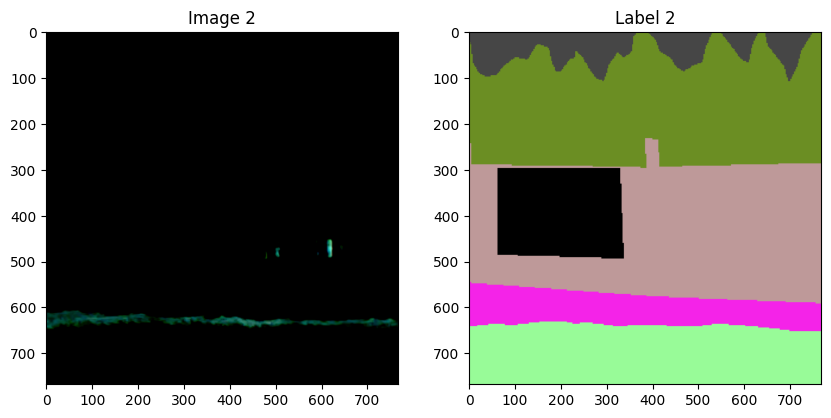

Sample 3:
  Image range: min=-1.8952821493148804, max=1.0713725090026855
  Unique labels in mask: [  0   1   2   5   7   8 255]
  Labels count: 7


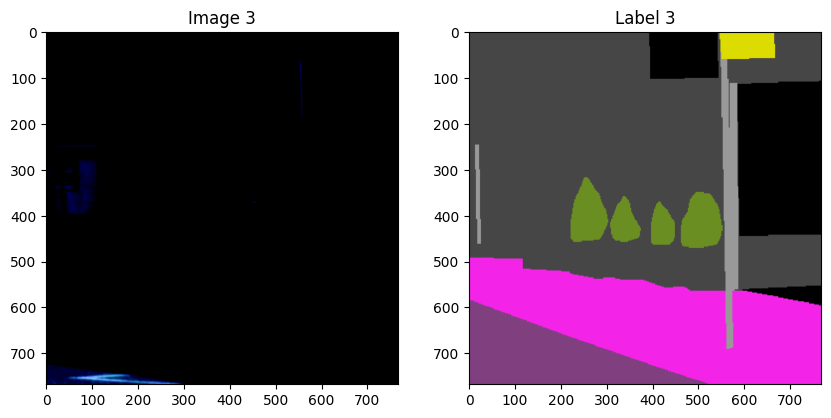

Sample 4:
  Image range: min=-1.946656346321106, max=2.6399998664855957
  Unique labels in mask: [  0   1   2   5   6   7   8  10  11  13 255]
  Labels count: 11


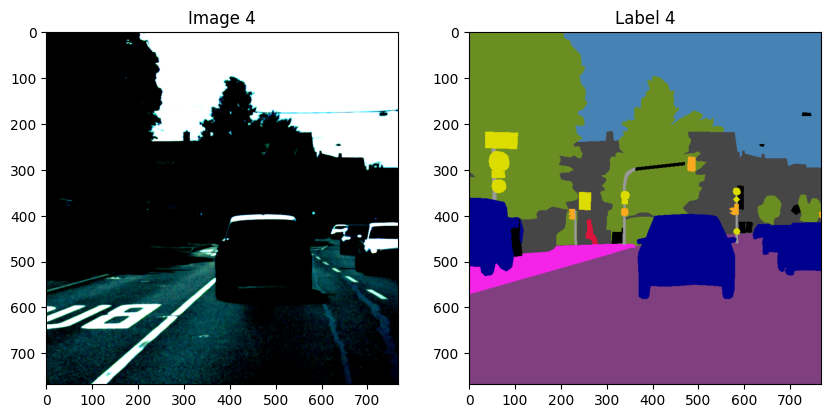

Sample 5:
  Image range: min=-1.2616662979125977, max=0.02562093548476696
  Unique labels in mask: [  0 255]
  Labels count: 2


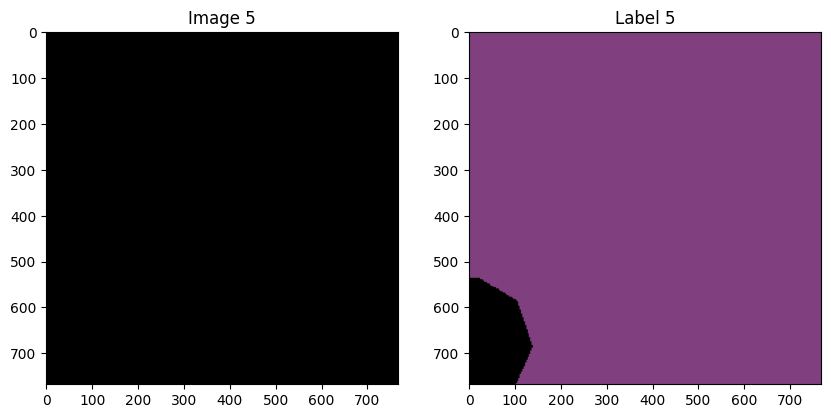

In [46]:
import colorsys
def give_color_to_seg_img(seg, n_classes):
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)  # Shape (H, W, 3)

    # Predefined color mapping for each class
    class_colors = [
        (0, (128, 64, 128)),   # Road
        (1, (244, 35, 232)),   # Sidewalk
        (2, (70, 70, 70)),    # Building
        (3, (102, 102, 156)), # Wall
        (4, (190, 153, 153)), # Fence
        (5, (153, 153, 153)), # Pole
        (6, (250, 170, 30)),  # Traffic Light
        (7, (220, 220, 0)),   # Traffic Sign
        (8, (107, 142, 35)),  # Vegetation
        (9, (152, 251, 152)), # Terrain
        (10, (70, 130, 180)),  # Sky
        (11, (220, 20, 60)),   # Person
        (12, (255, 0, 0)),     # Rider
        (13, (0, 0, 142)),     # Car
        (14, (0, 0, 70)),      # Truck
        (15, (0, 60, 100)),    # Bus
        (16, (0, 80, 100)),    # Train
        (17, (0, 0, 230)),     # Motorcycle
        (18, (119, 11, 32)),   # Bicycle
        (255, (0,  0,  0))   #Ignore Index
    ]

    # Create a dictionary for quick lookup of colors by class ID
    color_dict = {class_id: color for class_id, color in class_colors}

    for class_id, color in color_dict.items():
        seg_img[seg == class_id] = color  # Assign the corresponding RGB color

    return seg_img

def visualize_samples(dataset, num_samples=4, n_classes=20):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Get the unique labels in the mask
        unique_labels = np.unique(mask.numpy())
        print(f"Sample {i+1}:")
        print(f"  Image range: min={image.min()}, max={image.max()}")
        print(f"  Unique labels in mask: {unique_labels}")
        print(f"  Labels count: {len(unique_labels)}")

        mask_colored = give_color_to_seg_img(mask.numpy(), n_classes)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert back to HWC format
        plt.title(f"Image {i+1}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_colored)
        plt.title(f"Label {i+1}")

        plt.show()

# Example usage
visualize_samples(train_dataset, num_samples=5, n_classes=34)

In [15]:
def save_checkpoint(model, optimizer, epoch, loss, filename='best19_aug_focal_loss_kan_768*768_resize_model.pth'):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, filename)

def load_checkpoint(model, optimizer, filename='best19_aug_focal_loss_kan_768*768_resize_model.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [16]:
import torch.optim.lr_scheduler as lr_scheduler

class PolynomialLRDecay(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, max_iters, power=0.9, last_epoch=-1):
        self.max_iters = max_iters
        self.power = power
        super(PolynomialLRDecay, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * (1 - self.last_epoch / self.max_iters) ** self.power for base_lr in self.base_lrs]


In [17]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calculate_miou(preds, labels, n_classes, ignore_index=255):

    # Filter out ignore_index pixels
    keep = labels != ignore_index
    preds = preds[keep]
    labels = labels[keep]

    # Compute the confusion matrix
    hist = torch.bincount(
        labels * n_classes + preds,
        minlength=n_classes ** 2
    ).view(n_classes, n_classes)

    # Compute IoU
    intersection = torch.diag(hist)
    union = hist.sum(dim=0) + hist.sum(dim=1) - intersection
    ious = intersection / union.clamp(min=1e-6)  # Avoid division by zero
    miou = ious.mean().item()

    return miou, ious

def evaluate(model, val_loader, criterion, device, num_classes, ignore_index=255):

    model.eval()
    val_loss = 0.0
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=device)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating", leave=False):
            images = images.float().to(device)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Get predictions
            preds = outputs.argmax(dim=1)

            # Update the confusion matrix for mIoU
            keep = masks != ignore_index  # Filter out ignore_index pixels
            preds = preds[keep]
            masks = masks[keep]

            # Flatten and compute mIoU
            if preds.numel() > 0:  # Ensure there are valid pixels
                hist += torch.bincount(
                    masks * num_classes + preds,
                    minlength=num_classes ** 2
                ).view(num_classes, num_classes)

    # Calculate IoU and mIoU
    intersection = torch.diag(hist)
    union = hist.sum(dim=0) + hist.sum(dim=1) - intersection
    ious = intersection / union.clamp(min=1e-6)  # Avoid division by zero
    miou = ious.mean().item()

    val_loss /= len(val_loader.dataset)

    # Print results
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation mIoU: {miou:.4f}")
    print("IoU for each class:")
    for cls in range(num_classes):
        print(f"Class {cls}: IoU = {ious[cls].item():.4f}")

    return val_loss, miou, ious

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_classes, num_epochs, patience, ignore_index=255):

    best_miou = 0.0  # Initialize the best mIoU to 0
    patience_counter = 0  # Initialize patience counter

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(device)
            masks = masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        val_loss, miou, ious = evaluate(model, val_loader, criterion, device, num_classes, ignore_index)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val mIoU: {miou:.4f}')

        # Save checkpoint if mIoU improves
        if miou > best_miou:
            best_miou = miou
            save_checkpoint(model, optimizer, epoch + 1, best_miou)
            print(f'Saved best model with mIoU: {best_miou:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping if patience exceeded
        if patience_counter >= patience:
            print(f'Early stopping triggered. No improvement in mIoU for {patience} epochs.')
            break



In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean', ignore_index=255):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        # Compute Cross-Entropy Loss without reduction
        ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=self.ignore_index)(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # Apply the specified reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss  # 'none'

In [19]:
torch.cuda.empty_cache()
gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(in_channels=3, num_classes=19)
model = model.to(device)


In [57]:
torch.cuda.empty_cache()
gc.collect()
criterion = FocalLoss(gamma=3, ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4, nesterov=True)

root_dir = '/content/drive/MyDrive/ML_AV/Deeplab/cityscape'
train_set = CityscapesDataset(root_dir, mode='train')
val_set = CityscapesDataset(root_dir, mode='val')

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=4)

scheduler = PolynomialLRDecay(optimizer, max_iters=50 * len(train_loader))

In [58]:
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_classes=19, num_epochs=50, patience=10)

Validation Loss: 0.0461
Validation mIoU: 0.6955
IoU for each class:
Class 0: IoU = 0.9712
Class 1: IoU = 0.7803
Class 2: IoU = 0.8977
Class 3: IoU = 0.4770
Class 4: IoU = 0.5464
Class 5: IoU = 0.5037
Class 6: IoU = 0.5741
Class 7: IoU = 0.6631
Class 8: IoU = 0.9055
Class 9: IoU = 0.5678
Class 10: IoU = 0.9235
Class 11: IoU = 0.7334
Class 12: IoU = 0.5158
Class 13: IoU = 0.9255
Class 14: IoU = 0.6532
Class 15: IoU = 0.7402
Class 16: IoU = 0.5841
Class 17: IoU = 0.5532
Class 18: IoU = 0.6994
Epoch 1/50, Train Loss: 0.0616, Val Loss: 0.0461, Val mIoU: 0.6955
Saved best model with mIoU: 0.6955


Validation Loss: 0.0460
Validation mIoU: 0.6963
IoU for each class:
Class 0: IoU = 0.9703
Class 1: IoU = 0.7784
Class 2: IoU = 0.8980
Class 3: IoU = 0.4628
Class 4: IoU = 0.5420
Class 5: IoU = 0.5075
Class 6: IoU = 0.5742
Class 7: IoU = 0.6635
Class 8: IoU = 0.9050
Class 9: IoU = 0.5807
Class 10: IoU = 0.9239
Class 11: IoU = 0.7319
Class 12: IoU = 0.5025
Class 13: IoU = 0.9271
Class 14: IoU = 0.6825
Class 15: IoU = 0.7647
Class 16: IoU = 0.5757
Class 17: IoU = 0.5395
Class 18: IoU = 0.6993
Epoch 2/50, Train Loss: 0.0547, Val Loss: 0.0460, Val mIoU: 0.6963
Saved best model with mIoU: 0.6963


Validation Loss: 0.0461
Validation mIoU: 0.6966
IoU for each class:
Class 0: IoU = 0.9711
Class 1: IoU = 0.7807
Class 2: IoU = 0.8971
Class 3: IoU = 0.4661
Class 4: IoU = 0.5449
Class 5: IoU = 0.5030
Class 6: IoU = 0.5724
Class 7: IoU = 0.6576
Class 8: IoU = 0.9048
Class 9: IoU = 0.5732
Class 10: IoU = 0.9226
Class 11: IoU = 0.7323
Class 12: IoU = 0.5128
Class 13: IoU = 0.9275
Class 14: IoU = 0.6799
Class 15: IoU = 0.7557
Class 16: IoU = 0.5838
Class 17: IoU = 0.5519
Class 18: IoU = 0.6983
Epoch 3/50, Train Loss: 0.0556, Val Loss: 0.0461, Val mIoU: 0.6966
Saved best model with mIoU: 0.6966


Validation Loss: 0.0465
Validation mIoU: 0.6971
IoU for each class:
Class 0: IoU = 0.9697
Class 1: IoU = 0.7752
Class 2: IoU = 0.8980
Class 3: IoU = 0.4682
Class 4: IoU = 0.5442
Class 5: IoU = 0.5014
Class 6: IoU = 0.5705
Class 7: IoU = 0.6611
Class 8: IoU = 0.9039
Class 9: IoU = 0.5825
Class 10: IoU = 0.9247
Class 11: IoU = 0.7330
Class 12: IoU = 0.5094
Class 13: IoU = 0.9268
Class 14: IoU = 0.6869
Class 15: IoU = 0.7661
Class 16: IoU = 0.5833
Class 17: IoU = 0.5399
Class 18: IoU = 0.6993
Epoch 4/50, Train Loss: 0.0569, Val Loss: 0.0465, Val mIoU: 0.6971
Saved best model with mIoU: 0.6971


Validation Loss: 0.0467
Validation mIoU: 0.6924
IoU for each class:
Class 0: IoU = 0.9699
Class 1: IoU = 0.7735
Class 2: IoU = 0.8960
Class 3: IoU = 0.4466
Class 4: IoU = 0.5466
Class 5: IoU = 0.4922
Class 6: IoU = 0.5715
Class 7: IoU = 0.6555
Class 8: IoU = 0.9049
Class 9: IoU = 0.5578
Class 10: IoU = 0.9241
Class 11: IoU = 0.7307
Class 12: IoU = 0.5062
Class 13: IoU = 0.9254
Class 14: IoU = 0.6754
Class 15: IoU = 0.7341
Class 16: IoU = 0.5982
Class 17: IoU = 0.5487
Class 18: IoU = 0.6984
Epoch 5/50, Train Loss: 0.0575, Val Loss: 0.0467, Val mIoU: 0.6924


Validation Loss: 0.0463
Validation mIoU: 0.6967
IoU for each class:
Class 0: IoU = 0.9701
Class 1: IoU = 0.7751
Class 2: IoU = 0.8973
Class 3: IoU = 0.4393
Class 4: IoU = 0.5508
Class 5: IoU = 0.5064
Class 6: IoU = 0.5697
Class 7: IoU = 0.6616
Class 8: IoU = 0.9046
Class 9: IoU = 0.5730
Class 10: IoU = 0.9256
Class 11: IoU = 0.7323
Class 12: IoU = 0.5104
Class 13: IoU = 0.9259
Class 14: IoU = 0.6798
Class 15: IoU = 0.7531
Class 16: IoU = 0.6112
Class 17: IoU = 0.5527
Class 18: IoU = 0.6985
Epoch 6/50, Train Loss: 0.0571, Val Loss: 0.0463, Val mIoU: 0.6967


Validation Loss: 0.0466
Validation mIoU: 0.6917
IoU for each class:
Class 0: IoU = 0.9703
Class 1: IoU = 0.7738
Class 2: IoU = 0.8970
Class 3: IoU = 0.4401
Class 4: IoU = 0.5486
Class 5: IoU = 0.4992
Class 6: IoU = 0.5729
Class 7: IoU = 0.6562
Class 8: IoU = 0.9055
Class 9: IoU = 0.5627
Class 10: IoU = 0.9256
Class 11: IoU = 0.7322
Class 12: IoU = 0.5109
Class 13: IoU = 0.9249
Class 14: IoU = 0.6639
Class 15: IoU = 0.7218
Class 16: IoU = 0.5914
Class 17: IoU = 0.5470
Class 18: IoU = 0.6981
Epoch 7/50, Train Loss: 0.0550, Val Loss: 0.0466, Val mIoU: 0.6917


Validation Loss: 0.0458
Validation mIoU: 0.6979
IoU for each class:
Class 0: IoU = 0.9709
Class 1: IoU = 0.7790
Class 2: IoU = 0.8981
Class 3: IoU = 0.4699
Class 4: IoU = 0.5508
Class 5: IoU = 0.4998
Class 6: IoU = 0.5712
Class 7: IoU = 0.6580
Class 8: IoU = 0.9050
Class 9: IoU = 0.5725
Class 10: IoU = 0.9248
Class 11: IoU = 0.7319
Class 12: IoU = 0.5159
Class 13: IoU = 0.9267
Class 14: IoU = 0.6984
Class 15: IoU = 0.7530
Class 16: IoU = 0.5913
Class 17: IoU = 0.5460
Class 18: IoU = 0.6970
Epoch 8/50, Train Loss: 0.0558, Val Loss: 0.0458, Val mIoU: 0.6979
Saved best model with mIoU: 0.6979


Validation Loss: 0.0460
Validation mIoU: 0.6962
IoU for each class:
Class 0: IoU = 0.9707
Class 1: IoU = 0.7798
Class 2: IoU = 0.8973
Class 3: IoU = 0.4585
Class 4: IoU = 0.5461
Class 5: IoU = 0.4969
Class 6: IoU = 0.5735
Class 7: IoU = 0.6588
Class 8: IoU = 0.9051
Class 9: IoU = 0.5731
Class 10: IoU = 0.9248
Class 11: IoU = 0.7333
Class 12: IoU = 0.5125
Class 13: IoU = 0.9267
Class 14: IoU = 0.6946
Class 15: IoU = 0.7558
Class 16: IoU = 0.5741
Class 17: IoU = 0.5474
Class 18: IoU = 0.6997
Epoch 9/50, Train Loss: 0.0563, Val Loss: 0.0460, Val mIoU: 0.6962


Validation Loss: 0.0461
Validation mIoU: 0.6946
IoU for each class:
Class 0: IoU = 0.9712
Class 1: IoU = 0.7829
Class 2: IoU = 0.8979
Class 3: IoU = 0.4582
Class 4: IoU = 0.5444
Class 5: IoU = 0.4899
Class 6: IoU = 0.5718
Class 7: IoU = 0.6577
Class 8: IoU = 0.9049
Class 9: IoU = 0.5671
Class 10: IoU = 0.9264
Class 11: IoU = 0.7291
Class 12: IoU = 0.5038
Class 13: IoU = 0.9236
Class 14: IoU = 0.6724
Class 15: IoU = 0.7568
Class 16: IoU = 0.6052
Class 17: IoU = 0.5360
Class 18: IoU = 0.6983
Epoch 10/50, Train Loss: 0.0587, Val Loss: 0.0461, Val mIoU: 0.6946


Validation Loss: 0.0460
Validation mIoU: 0.6966
IoU for each class:
Class 0: IoU = 0.9711
Class 1: IoU = 0.7816
Class 2: IoU = 0.8970
Class 3: IoU = 0.4534
Class 4: IoU = 0.5470
Class 5: IoU = 0.5008
Class 6: IoU = 0.5746
Class 7: IoU = 0.6601
Class 8: IoU = 0.9038
Class 9: IoU = 0.5679
Class 10: IoU = 0.9252
Class 11: IoU = 0.7318
Class 12: IoU = 0.5134
Class 13: IoU = 0.9249
Class 14: IoU = 0.6698
Class 15: IoU = 0.7546
Class 16: IoU = 0.6054
Class 17: IoU = 0.5552
Class 18: IoU = 0.6982
Epoch 11/50, Train Loss: 0.0590, Val Loss: 0.0460, Val mIoU: 0.6966


Validation Loss: 0.0458
Validation mIoU: 0.6997
IoU for each class:
Class 0: IoU = 0.9706
Class 1: IoU = 0.7785
Class 2: IoU = 0.8983
Class 3: IoU = 0.4756
Class 4: IoU = 0.5508
Class 5: IoU = 0.5014
Class 6: IoU = 0.5711
Class 7: IoU = 0.6590
Class 8: IoU = 0.9050
Class 9: IoU = 0.5735
Class 10: IoU = 0.9243
Class 11: IoU = 0.7306
Class 12: IoU = 0.5131
Class 13: IoU = 0.9272
Class 14: IoU = 0.6964
Class 15: IoU = 0.7662
Class 16: IoU = 0.6047
Class 17: IoU = 0.5492
Class 18: IoU = 0.6997
Epoch 12/50, Train Loss: 0.0554, Val Loss: 0.0458, Val mIoU: 0.6997
Saved best model with mIoU: 0.6997


Validation Loss: 0.0466
Validation mIoU: 0.6978
IoU for each class:
Class 0: IoU = 0.9696
Class 1: IoU = 0.7736
Class 2: IoU = 0.8971
Class 3: IoU = 0.4683
Class 4: IoU = 0.5386
Class 5: IoU = 0.5023
Class 6: IoU = 0.5718
Class 7: IoU = 0.6612
Class 8: IoU = 0.9039
Class 9: IoU = 0.5801
Class 10: IoU = 0.9261
Class 11: IoU = 0.7302
Class 12: IoU = 0.5080
Class 13: IoU = 0.9255
Class 14: IoU = 0.6913
Class 15: IoU = 0.7621
Class 16: IoU = 0.5929
Class 17: IoU = 0.5594
Class 18: IoU = 0.6971
Epoch 13/50, Train Loss: 0.0585, Val Loss: 0.0466, Val mIoU: 0.6978


Validation Loss: 0.0459
Validation mIoU: 0.7006
IoU for each class:
Class 0: IoU = 0.9706
Class 1: IoU = 0.7810
Class 2: IoU = 0.8976
Class 3: IoU = 0.4826
Class 4: IoU = 0.5496
Class 5: IoU = 0.4927
Class 6: IoU = 0.5702
Class 7: IoU = 0.6604
Class 8: IoU = 0.9042
Class 9: IoU = 0.5880
Class 10: IoU = 0.9254
Class 11: IoU = 0.7306
Class 12: IoU = 0.5068
Class 13: IoU = 0.9260
Class 14: IoU = 0.6974
Class 15: IoU = 0.7657
Class 16: IoU = 0.6065
Class 17: IoU = 0.5559
Class 18: IoU = 0.6999
Epoch 14/50, Train Loss: 0.0574, Val Loss: 0.0459, Val mIoU: 0.7006
Saved best model with mIoU: 0.7006


Validation Loss: 0.0456
Validation mIoU: 0.7005
IoU for each class:
Class 0: IoU = 0.9711
Class 1: IoU = 0.7816
Class 2: IoU = 0.8982
Class 3: IoU = 0.4948
Class 4: IoU = 0.5478
Class 5: IoU = 0.4904
Class 6: IoU = 0.5742
Class 7: IoU = 0.6611
Class 8: IoU = 0.9048
Class 9: IoU = 0.5778
Class 10: IoU = 0.9253
Class 11: IoU = 0.7313
Class 12: IoU = 0.5038
Class 13: IoU = 0.9273
Class 14: IoU = 0.6957
Class 15: IoU = 0.7701
Class 16: IoU = 0.6088
Class 17: IoU = 0.5451
Class 18: IoU = 0.7008
Epoch 15/50, Train Loss: 0.0561, Val Loss: 0.0456, Val mIoU: 0.7005


Validation Loss: 0.0461
Validation mIoU: 0.6939
IoU for each class:
Class 0: IoU = 0.9712
Class 1: IoU = 0.7811
Class 2: IoU = 0.8968
Class 3: IoU = 0.4493
Class 4: IoU = 0.5436
Class 5: IoU = 0.4875
Class 6: IoU = 0.5748
Class 7: IoU = 0.6537
Class 8: IoU = 0.9050
Class 9: IoU = 0.5713
Class 10: IoU = 0.9242
Class 11: IoU = 0.7312
Class 12: IoU = 0.5039
Class 13: IoU = 0.9265
Class 14: IoU = 0.6832
Class 15: IoU = 0.7634
Class 16: IoU = 0.5955
Class 17: IoU = 0.5229
Class 18: IoU = 0.6986
Epoch 16/50, Train Loss: 0.0564, Val Loss: 0.0461, Val mIoU: 0.6939


Validation Loss: 0.0459
Validation mIoU: 0.6985
IoU for each class:
Class 0: IoU = 0.9715
Class 1: IoU = 0.7830
Class 2: IoU = 0.8972
Class 3: IoU = 0.4848
Class 4: IoU = 0.5446
Class 5: IoU = 0.5043
Class 6: IoU = 0.5738
Class 7: IoU = 0.6596
Class 8: IoU = 0.9050
Class 9: IoU = 0.5711
Class 10: IoU = 0.9238
Class 11: IoU = 0.7279
Class 12: IoU = 0.4948
Class 13: IoU = 0.9265
Class 14: IoU = 0.7006
Class 15: IoU = 0.7647
Class 16: IoU = 0.5969
Class 17: IoU = 0.5411
Class 18: IoU = 0.6999
Epoch 17/50, Train Loss: 0.0578, Val Loss: 0.0459, Val mIoU: 0.6985


Validation Loss: 0.0460
Validation mIoU: 0.6991
IoU for each class:
Class 0: IoU = 0.9705
Class 1: IoU = 0.7802
Class 2: IoU = 0.8980
Class 3: IoU = 0.4750
Class 4: IoU = 0.5472
Class 5: IoU = 0.5003
Class 6: IoU = 0.5713
Class 7: IoU = 0.6623
Class 8: IoU = 0.9040
Class 9: IoU = 0.5768
Class 10: IoU = 0.9258
Class 11: IoU = 0.7330
Class 12: IoU = 0.5116
Class 13: IoU = 0.9259
Class 14: IoU = 0.6861
Class 15: IoU = 0.7604
Class 16: IoU = 0.6103
Class 17: IoU = 0.5454
Class 18: IoU = 0.6990
Epoch 18/50, Train Loss: 0.0578, Val Loss: 0.0460, Val mIoU: 0.6991


Validation Loss: 0.0457
Validation mIoU: 0.7001
IoU for each class:
Class 0: IoU = 0.9712
Class 1: IoU = 0.7824
Class 2: IoU = 0.8981
Class 3: IoU = 0.4762
Class 4: IoU = 0.5472
Class 5: IoU = 0.4929
Class 6: IoU = 0.5749
Class 7: IoU = 0.6574
Class 8: IoU = 0.9045
Class 9: IoU = 0.5750
Class 10: IoU = 0.9254
Class 11: IoU = 0.7321
Class 12: IoU = 0.5070
Class 13: IoU = 0.9270
Class 14: IoU = 0.7130
Class 15: IoU = 0.7682
Class 16: IoU = 0.6058
Class 17: IoU = 0.5442
Class 18: IoU = 0.6988
Epoch 19/50, Train Loss: 0.0564, Val Loss: 0.0457, Val mIoU: 0.7001


Validation Loss: 0.0458
Validation mIoU: 0.7007
IoU for each class:
Class 0: IoU = 0.9713
Class 1: IoU = 0.7838
Class 2: IoU = 0.8981
Class 3: IoU = 0.4773
Class 4: IoU = 0.5481
Class 5: IoU = 0.5056
Class 6: IoU = 0.5743
Class 7: IoU = 0.6630
Class 8: IoU = 0.9044
Class 9: IoU = 0.5762
Class 10: IoU = 0.9265
Class 11: IoU = 0.7318
Class 12: IoU = 0.5068
Class 13: IoU = 0.9258
Class 14: IoU = 0.6981
Class 15: IoU = 0.7680
Class 16: IoU = 0.6035
Class 17: IoU = 0.5528
Class 18: IoU = 0.6984
Epoch 20/50, Train Loss: 0.0565, Val Loss: 0.0458, Val mIoU: 0.7007
Saved best model with mIoU: 0.7007


Validation Loss: 0.0456
Validation mIoU: 0.6988
IoU for each class:
Class 0: IoU = 0.9712
Class 1: IoU = 0.7834
Class 2: IoU = 0.8984
Class 3: IoU = 0.4691
Class 4: IoU = 0.5520
Class 5: IoU = 0.5006
Class 6: IoU = 0.5719
Class 7: IoU = 0.6572
Class 8: IoU = 0.9048
Class 9: IoU = 0.5833
Class 10: IoU = 0.9258
Class 11: IoU = 0.7323
Class 12: IoU = 0.5121
Class 13: IoU = 0.9246
Class 14: IoU = 0.6875
Class 15: IoU = 0.7648
Class 16: IoU = 0.5913
Class 17: IoU = 0.5460
Class 18: IoU = 0.7005
Epoch 21/50, Train Loss: 0.0574, Val Loss: 0.0456, Val mIoU: 0.6988


Validation Loss: 0.0455
Validation mIoU: 0.6990
IoU for each class:
Class 0: IoU = 0.9701
Class 1: IoU = 0.7772
Class 2: IoU = 0.8989
Class 3: IoU = 0.4818
Class 4: IoU = 0.5489
Class 5: IoU = 0.4940
Class 6: IoU = 0.5735
Class 7: IoU = 0.6624
Class 8: IoU = 0.9048
Class 9: IoU = 0.5812
Class 10: IoU = 0.9258
Class 11: IoU = 0.7323
Class 12: IoU = 0.5123
Class 13: IoU = 0.9265
Class 14: IoU = 0.7050
Class 15: IoU = 0.7670
Class 16: IoU = 0.5828
Class 17: IoU = 0.5377
Class 18: IoU = 0.6994
Epoch 22/50, Train Loss: 0.0574, Val Loss: 0.0455, Val mIoU: 0.6990


Validation Loss: 0.0457
Validation mIoU: 0.6987
IoU for each class:
Class 0: IoU = 0.9715
Class 1: IoU = 0.7841
Class 2: IoU = 0.8979
Class 3: IoU = 0.4744
Class 4: IoU = 0.5513
Class 5: IoU = 0.5010
Class 6: IoU = 0.5706
Class 7: IoU = 0.6599
Class 8: IoU = 0.9046
Class 9: IoU = 0.5777
Class 10: IoU = 0.9251
Class 11: IoU = 0.7301
Class 12: IoU = 0.5109
Class 13: IoU = 0.9260
Class 14: IoU = 0.6901
Class 15: IoU = 0.7592
Class 16: IoU = 0.5981
Class 17: IoU = 0.5426
Class 18: IoU = 0.6995
Epoch 23/50, Train Loss: 0.0574, Val Loss: 0.0457, Val mIoU: 0.6987


Validation Loss: 0.0455
Validation mIoU: 0.6999
IoU for each class:
Class 0: IoU = 0.9711
Class 1: IoU = 0.7829
Class 2: IoU = 0.8985
Class 3: IoU = 0.4873
Class 4: IoU = 0.5479
Class 5: IoU = 0.4985
Class 6: IoU = 0.5736
Class 7: IoU = 0.6592
Class 8: IoU = 0.9043
Class 9: IoU = 0.5762
Class 10: IoU = 0.9244
Class 11: IoU = 0.7325
Class 12: IoU = 0.5127
Class 13: IoU = 0.9269
Class 14: IoU = 0.6982
Class 15: IoU = 0.7668
Class 16: IoU = 0.5979
Class 17: IoU = 0.5405
Class 18: IoU = 0.6989
Epoch 24/50, Train Loss: 0.0553, Val Loss: 0.0455, Val mIoU: 0.6999


Validation Loss: 0.0455
Validation mIoU: 0.6991
IoU for each class:
Class 0: IoU = 0.9715
Class 1: IoU = 0.7841
Class 2: IoU = 0.8973
Class 3: IoU = 0.4495
Class 4: IoU = 0.5480
Class 5: IoU = 0.4939
Class 6: IoU = 0.5753
Class 7: IoU = 0.6577
Class 8: IoU = 0.9044
Class 9: IoU = 0.5779
Class 10: IoU = 0.9250
Class 11: IoU = 0.7346
Class 12: IoU = 0.5225
Class 13: IoU = 0.9272
Class 14: IoU = 0.6982
Class 15: IoU = 0.7665
Class 16: IoU = 0.5998
Class 17: IoU = 0.5506
Class 18: IoU = 0.6980
Epoch 25/50, Train Loss: 0.0547, Val Loss: 0.0455, Val mIoU: 0.6991


Validation Loss: 0.0458
Validation mIoU: 0.6978
IoU for each class:
Class 0: IoU = 0.9706
Class 1: IoU = 0.7810
Class 2: IoU = 0.8970
Class 3: IoU = 0.4589
Class 4: IoU = 0.5480
Class 5: IoU = 0.5003
Class 6: IoU = 0.5744
Class 7: IoU = 0.6628
Class 8: IoU = 0.9042
Class 9: IoU = 0.5791
Class 10: IoU = 0.9247
Class 11: IoU = 0.7321
Class 12: IoU = 0.5122
Class 13: IoU = 0.9265
Class 14: IoU = 0.6923
Class 15: IoU = 0.7644
Class 16: IoU = 0.5983
Class 17: IoU = 0.5324
Class 18: IoU = 0.6999
Epoch 26/50, Train Loss: 0.0563, Val Loss: 0.0458, Val mIoU: 0.6978


Validation Loss: 0.0453
Validation mIoU: 0.7013
IoU for each class:
Class 0: IoU = 0.9713
Class 1: IoU = 0.7824
Class 2: IoU = 0.8987
Class 3: IoU = 0.4896
Class 4: IoU = 0.5510
Class 5: IoU = 0.5004
Class 6: IoU = 0.5721
Class 7: IoU = 0.6590
Class 8: IoU = 0.9051
Class 9: IoU = 0.5753
Class 10: IoU = 0.9262
Class 11: IoU = 0.7332
Class 12: IoU = 0.5158
Class 13: IoU = 0.9269
Class 14: IoU = 0.7078
Class 15: IoU = 0.7691
Class 16: IoU = 0.5986
Class 17: IoU = 0.5438
Class 18: IoU = 0.6987
Epoch 27/50, Train Loss: 0.0555, Val Loss: 0.0453, Val mIoU: 0.7013
Saved best model with mIoU: 0.7013


Validation Loss: 0.0459
Validation mIoU: 0.6961
IoU for each class:
Class 0: IoU = 0.9708
Class 1: IoU = 0.7815
Class 2: IoU = 0.8974
Class 3: IoU = 0.4601
Class 4: IoU = 0.5491
Class 5: IoU = 0.5020
Class 6: IoU = 0.5739
Class 7: IoU = 0.6601
Class 8: IoU = 0.9048
Class 9: IoU = 0.5837
Class 10: IoU = 0.9240
Class 11: IoU = 0.7278
Class 12: IoU = 0.5009
Class 13: IoU = 0.9259
Class 14: IoU = 0.6966
Class 15: IoU = 0.7650
Class 16: IoU = 0.5780
Class 17: IoU = 0.5263
Class 18: IoU = 0.6980
Epoch 28/50, Train Loss: 0.0576, Val Loss: 0.0459, Val mIoU: 0.6961


Validation Loss: 0.0460
Validation mIoU: 0.6939
IoU for each class:
Class 0: IoU = 0.9720
Class 1: IoU = 0.7854
Class 2: IoU = 0.8964
Class 3: IoU = 0.4369
Class 4: IoU = 0.5432
Class 5: IoU = 0.4940
Class 6: IoU = 0.5723
Class 7: IoU = 0.6583
Class 8: IoU = 0.9042
Class 9: IoU = 0.5709
Class 10: IoU = 0.9247
Class 11: IoU = 0.7327
Class 12: IoU = 0.5119
Class 13: IoU = 0.9261
Class 14: IoU = 0.6784
Class 15: IoU = 0.7581
Class 16: IoU = 0.5800
Class 17: IoU = 0.5405
Class 18: IoU = 0.6974
Epoch 29/50, Train Loss: 0.0552, Val Loss: 0.0460, Val mIoU: 0.6939


Validation Loss: 0.0454
Validation mIoU: 0.6989
IoU for each class:
Class 0: IoU = 0.9715
Class 1: IoU = 0.7843
Class 2: IoU = 0.8984
Class 3: IoU = 0.4756
Class 4: IoU = 0.5510
Class 5: IoU = 0.4883
Class 6: IoU = 0.5748
Class 7: IoU = 0.6585
Class 8: IoU = 0.9043
Class 9: IoU = 0.5814
Class 10: IoU = 0.9255
Class 11: IoU = 0.7325
Class 12: IoU = 0.5134
Class 13: IoU = 0.9259
Class 14: IoU = 0.6966
Class 15: IoU = 0.7632
Class 16: IoU = 0.5910
Class 17: IoU = 0.5453
Class 18: IoU = 0.6979
Epoch 30/50, Train Loss: 0.0589, Val Loss: 0.0454, Val mIoU: 0.6989


Validation Loss: 0.0460
Validation mIoU: 0.6985
IoU for each class:
Class 0: IoU = 0.9706
Class 1: IoU = 0.7798
Class 2: IoU = 0.8970
Class 3: IoU = 0.4364
Class 4: IoU = 0.5448
Class 5: IoU = 0.4971
Class 6: IoU = 0.5729
Class 7: IoU = 0.6568
Class 8: IoU = 0.9043
Class 9: IoU = 0.5817
Class 10: IoU = 0.9244
Class 11: IoU = 0.7336
Class 12: IoU = 0.5198
Class 13: IoU = 0.9271
Class 14: IoU = 0.7015
Class 15: IoU = 0.7697
Class 16: IoU = 0.6013
Class 17: IoU = 0.5557
Class 18: IoU = 0.6976
Epoch 31/50, Train Loss: 0.0542, Val Loss: 0.0460, Val mIoU: 0.6985


Validation Loss: 0.0458
Validation mIoU: 0.6983
IoU for each class:
Class 0: IoU = 0.9710
Class 1: IoU = 0.7819
Class 2: IoU = 0.8985
Class 3: IoU = 0.4660
Class 4: IoU = 0.5474
Class 5: IoU = 0.5013
Class 6: IoU = 0.5733
Class 7: IoU = 0.6573
Class 8: IoU = 0.9048
Class 9: IoU = 0.5782
Class 10: IoU = 0.9246
Class 11: IoU = 0.7345
Class 12: IoU = 0.5218
Class 13: IoU = 0.9253
Class 14: IoU = 0.6852
Class 15: IoU = 0.7611
Class 16: IoU = 0.5927
Class 17: IoU = 0.5489
Class 18: IoU = 0.6946
Epoch 32/50, Train Loss: 0.0573, Val Loss: 0.0458, Val mIoU: 0.6983


Validation Loss: 0.0457
Validation mIoU: 0.6996
IoU for each class:
Class 0: IoU = 0.9710
Class 1: IoU = 0.7815
Class 2: IoU = 0.8987
Class 3: IoU = 0.4788
Class 4: IoU = 0.5486
Class 5: IoU = 0.4973
Class 6: IoU = 0.5726
Class 7: IoU = 0.6597
Class 8: IoU = 0.9042
Class 9: IoU = 0.5839
Class 10: IoU = 0.9246
Class 11: IoU = 0.7309
Class 12: IoU = 0.5156
Class 13: IoU = 0.9258
Class 14: IoU = 0.7076
Class 15: IoU = 0.7676
Class 16: IoU = 0.5888
Class 17: IoU = 0.5390
Class 18: IoU = 0.6960
Epoch 33/50, Train Loss: 0.0551, Val Loss: 0.0457, Val mIoU: 0.6996


Validation Loss: 0.0457
Validation mIoU: 0.7005
IoU for each class:
Class 0: IoU = 0.9713
Class 1: IoU = 0.7832
Class 2: IoU = 0.8982
Class 3: IoU = 0.4972
Class 4: IoU = 0.5516
Class 5: IoU = 0.4999
Class 6: IoU = 0.5732
Class 7: IoU = 0.6621
Class 8: IoU = 0.9046
Class 9: IoU = 0.5771
Class 10: IoU = 0.9238
Class 11: IoU = 0.7336
Class 12: IoU = 0.5192
Class 13: IoU = 0.9258
Class 14: IoU = 0.6716
Class 15: IoU = 0.7567
Class 16: IoU = 0.6078
Class 17: IoU = 0.5546
Class 18: IoU = 0.6985
Epoch 34/50, Train Loss: 0.0545, Val Loss: 0.0457, Val mIoU: 0.7005


Validation Loss: 0.0458
Validation mIoU: 0.6993
IoU for each class:
Class 0: IoU = 0.9707
Class 1: IoU = 0.7797
Class 2: IoU = 0.8978
Class 3: IoU = 0.4850
Class 4: IoU = 0.5468
Class 5: IoU = 0.4987
Class 6: IoU = 0.5728
Class 7: IoU = 0.6580
Class 8: IoU = 0.9048
Class 9: IoU = 0.5766
Class 10: IoU = 0.9233
Class 11: IoU = 0.7327
Class 12: IoU = 0.5191
Class 13: IoU = 0.9261
Class 14: IoU = 0.6841
Class 15: IoU = 0.7627
Class 16: IoU = 0.5917
Class 17: IoU = 0.5565
Class 18: IoU = 0.6991
Epoch 35/50, Train Loss: 0.0555, Val Loss: 0.0458, Val mIoU: 0.6993


Validation Loss: 0.0459
Validation mIoU: 0.6952
IoU for each class:
Class 0: IoU = 0.9708
Class 1: IoU = 0.7777
Class 2: IoU = 0.8980
Class 3: IoU = 0.4744
Class 4: IoU = 0.5504
Class 5: IoU = 0.4964
Class 6: IoU = 0.5762
Class 7: IoU = 0.6604
Class 8: IoU = 0.9051
Class 9: IoU = 0.5630
Class 10: IoU = 0.9232
Class 11: IoU = 0.7324
Class 12: IoU = 0.5140
Class 13: IoU = 0.9253
Class 14: IoU = 0.6641
Class 15: IoU = 0.7623
Class 16: IoU = 0.5804
Class 17: IoU = 0.5363
Class 18: IoU = 0.6978
Epoch 36/50, Train Loss: 0.0547, Val Loss: 0.0459, Val mIoU: 0.6952


Validation Loss: 0.0458
Validation mIoU: 0.6984
IoU for each class:
Class 0: IoU = 0.9710
Class 1: IoU = 0.7816
Class 2: IoU = 0.8983
Class 3: IoU = 0.4799
Class 4: IoU = 0.5465
Class 5: IoU = 0.4999
Class 6: IoU = 0.5749
Class 7: IoU = 0.6630
Class 8: IoU = 0.9041
Class 9: IoU = 0.5749
Class 10: IoU = 0.9246
Class 11: IoU = 0.7329
Class 12: IoU = 0.5194
Class 13: IoU = 0.9248
Class 14: IoU = 0.6779
Class 15: IoU = 0.7578
Class 16: IoU = 0.5886
Class 17: IoU = 0.5506
Class 18: IoU = 0.6990
Epoch 37/50, Train Loss: 0.0561, Val Loss: 0.0458, Val mIoU: 0.6984
Early stopping triggered. No improvement in mIoU for 10 epochs.


In [47]:
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
def denormalize(image, mean, std):
    # Convert the image to float if it's not
    image = image.astype(np.float32)

    # Ensure mean and std are numpy arrays
    mean = np.array(mean)
    std = np.array(std)

    # Denormalize each channel (R, G, B)
    for i in range(3):
        image[..., i] = image[..., i] * std[i] + mean[i]

    return np.clip(image, 0, 1)  # Ensure pixel values are within [0, 1]

# Updated demo_inference function
def demo_inference(
    model, dataset, n_classes=34, num_samples=10,
    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
    ignore_label=255):

    model.eval()
    start = random.randint(0, len(dataset) - num_samples)

    for i in range(start, start + num_samples):
        # Load and preprocess the sample
        image, mask = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC
        image_np = denormalize(image_np, mean=mean, std=std)  # Denormalize image
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        input_image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        with torch.no_grad():
            output = model(input_image)
            predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Handle "uncare" regions in ground truth and prediction
        valid_mask = mask.numpy() != ignore_label
        ground_truth_img = give_color_to_seg_img(mask.numpy(), n_classes)
        predicted_mask_img = give_color_to_seg_img(predicted_mask, n_classes)

        # Overlay valid regions only
        overlay = image_np.copy()
        overlay[valid_mask] = (
            0.6 * image_np[valid_mask] + 0.4 * (predicted_mask_img[valid_mask] / 255.0)
        )
        overlay = np.clip(overlay, 0, 1)  # Ensure values are within [0, 1]

        # Plot the visualizations
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(ground_truth_img)
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis("off")

        axes[2].imshow(predicted_mask_img)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        axes[3].imshow(overlay)
        axes[3].set_title("Overlay (Prediction + Original)")
        axes[3].axis("off")

        plt.show()





In [59]:
# Load the model and checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('best19_aug_focal_loss_kan_768*768_resize_model.pth', map_location=device)

# Assuming your model is already defined
model = DeepLabV3Plus(num_classes=19,in_channels=3).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

val_loss, val_accuracy, overall_miou = evaluate(model, val_loader, criterion, device, num_classes=19)

<ipython-input-59-eb5afb6ae30f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best19_aug_focal_loss_kan_768*768_resize_model.pth', map_location=d

Validation Loss: 0.0453
Validation mIoU: 0.7013
IoU for each class:
Class 0: IoU = 0.9713
Class 1: IoU = 0.7824
Class 2: IoU = 0.8987
Class 3: IoU = 0.4896
Class 4: IoU = 0.5510
Class 5: IoU = 0.5004
Class 6: IoU = 0.5721
Class 7: IoU = 0.6590
Class 8: IoU = 0.9051
Class 9: IoU = 0.5753
Class 10: IoU = 0.9262
Class 11: IoU = 0.7332
Class 12: IoU = 0.5158
Class 13: IoU = 0.9269
Class 14: IoU = 0.7078
Class 15: IoU = 0.7691
Class 16: IoU = 0.5986
Class 17: IoU = 0.5438
Class 18: IoU = 0.6987


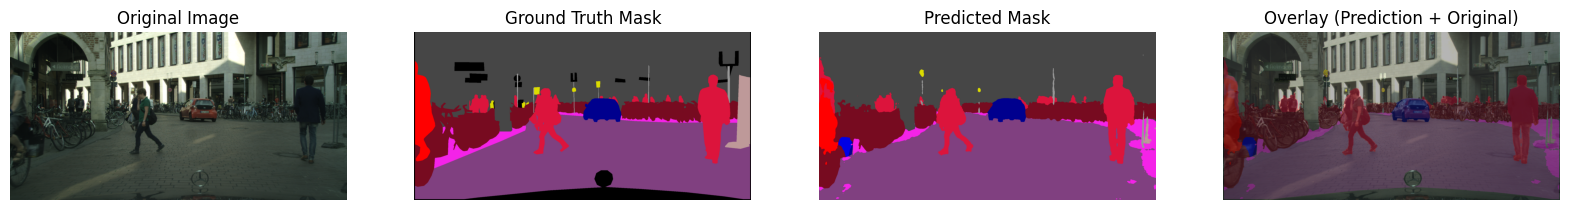

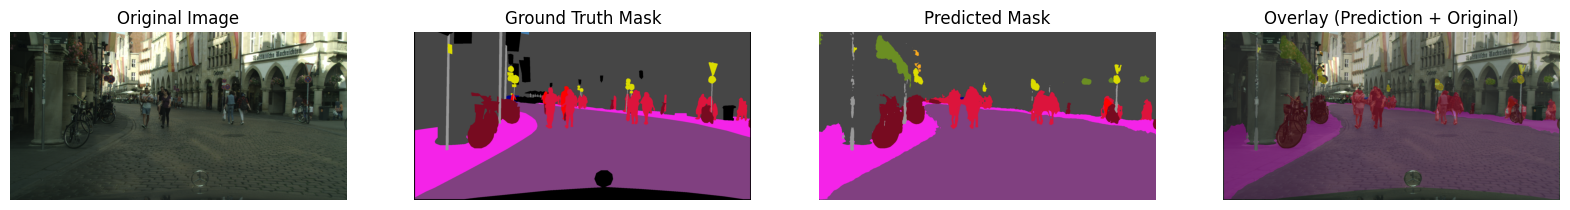

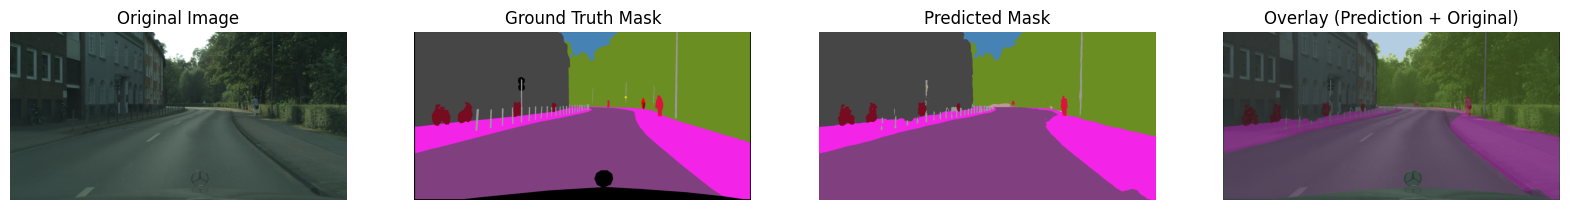

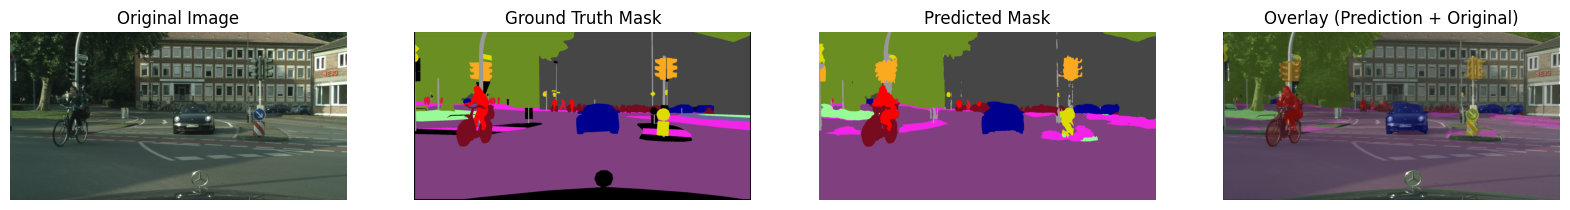

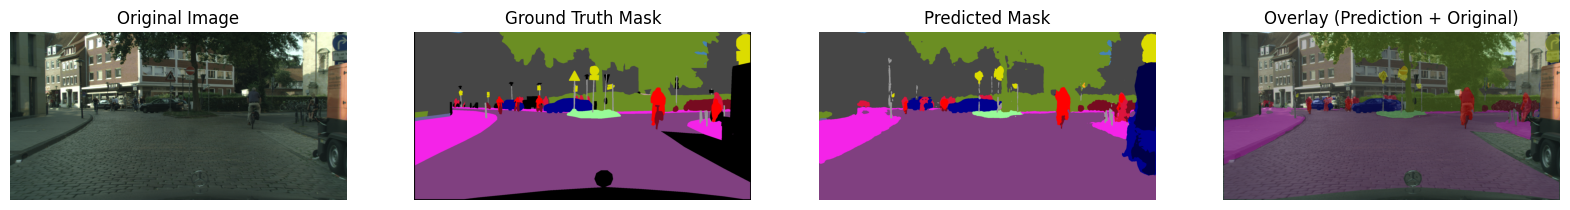

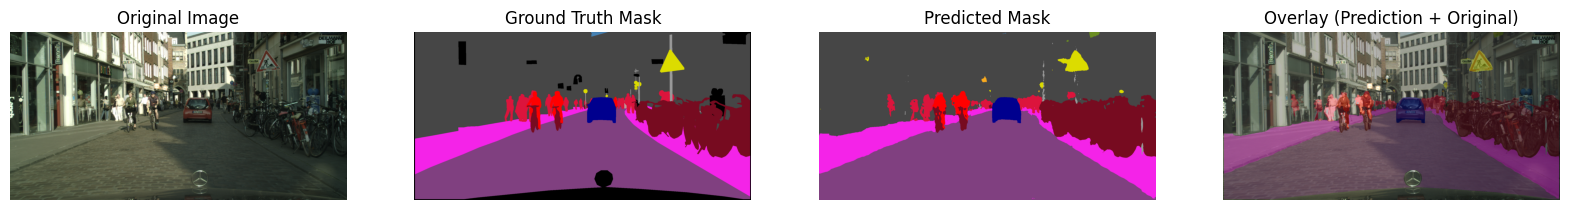

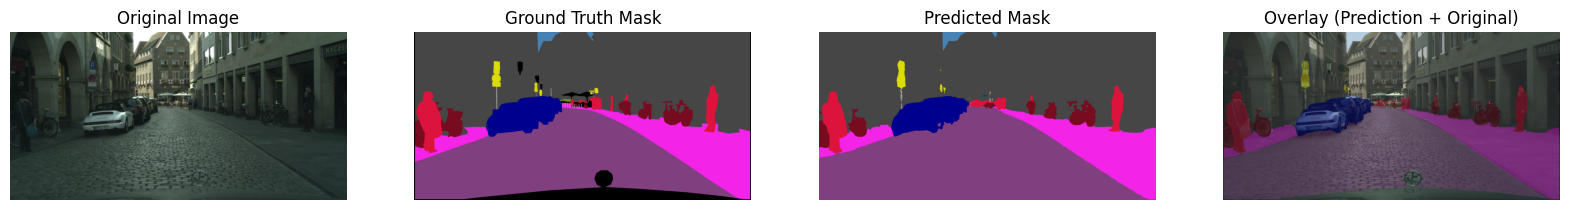

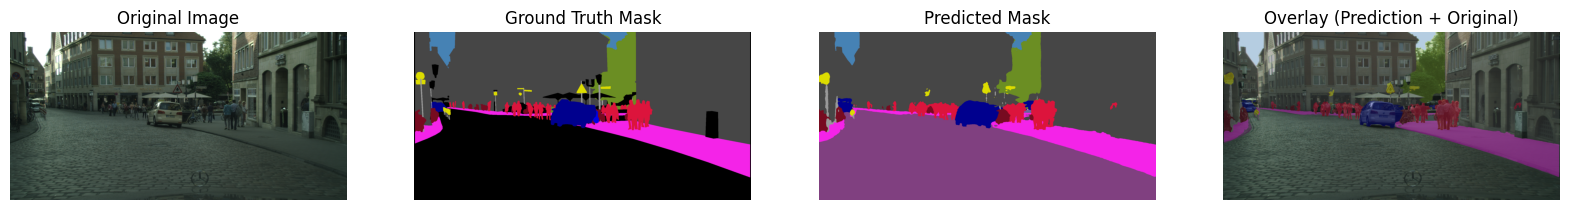

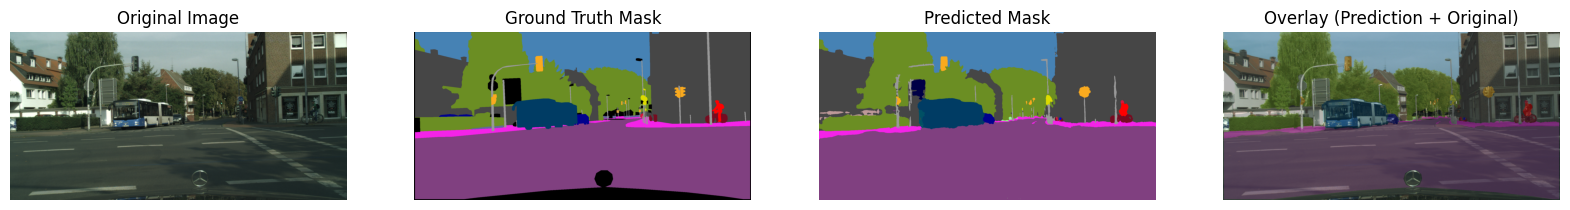

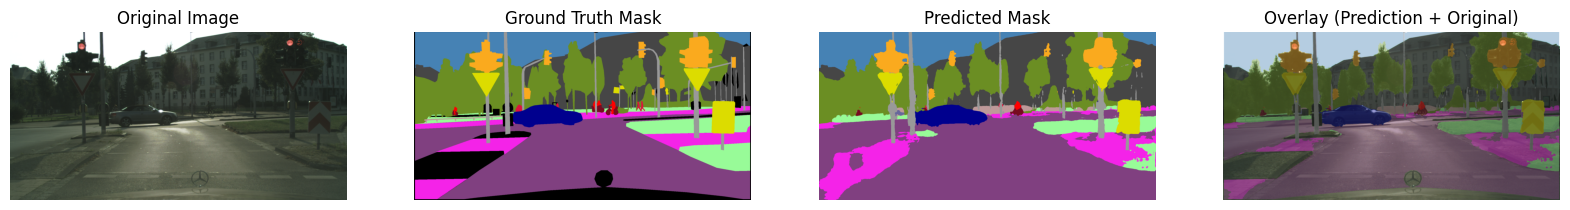

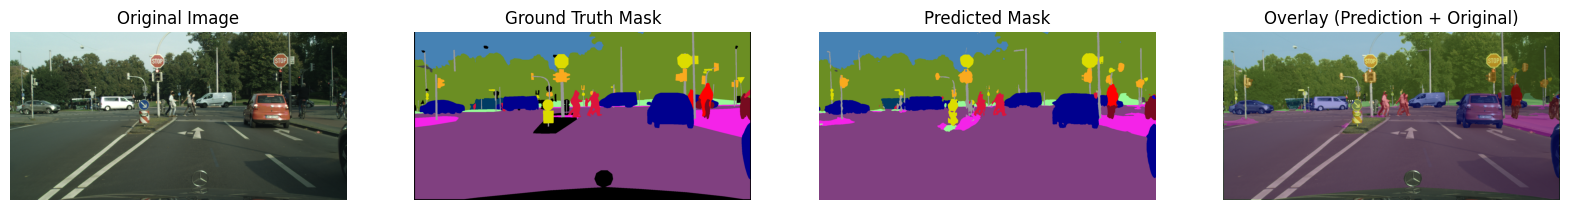

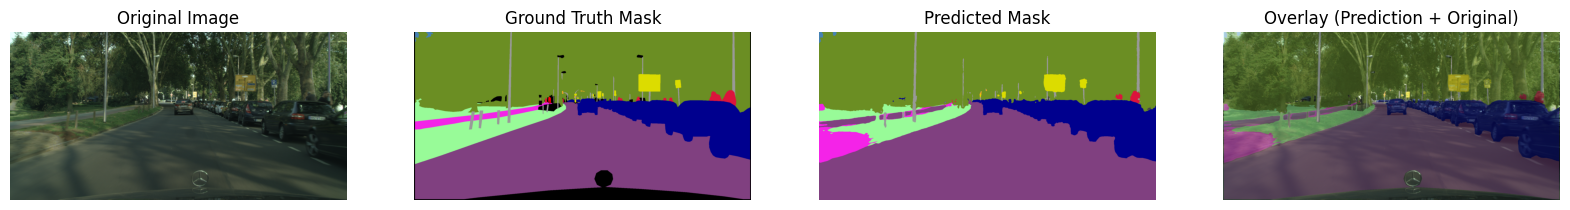

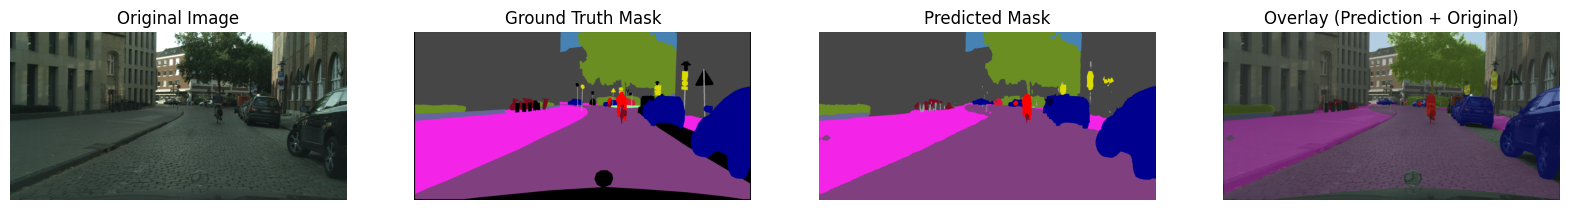

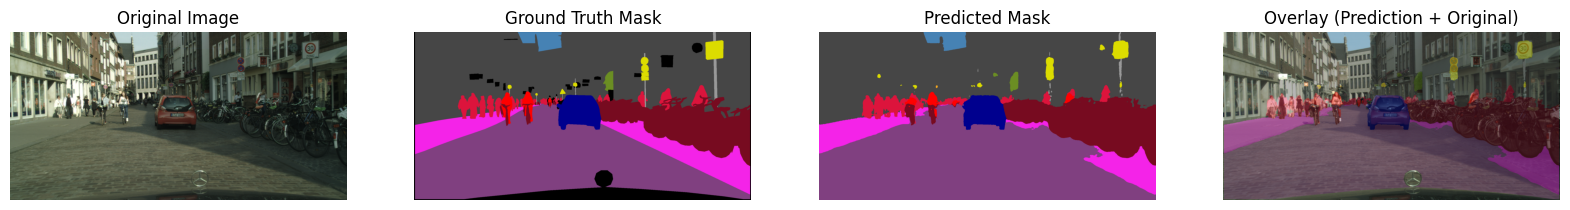

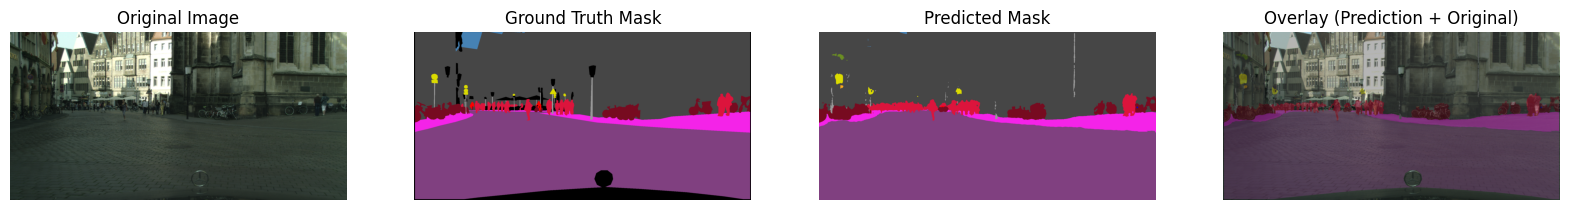

In [64]:
# Replace `val_dataset` with your dataset instance
demo_inference(model, val_set, n_classes=19, num_samples=15)